## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [15]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env1 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
from TCGame_Env1 import TicTacToe as env

In [16]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [17]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [18]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [7]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, epsilon_value):
    x = np.random.random()    
    q_state = Q_state(state)
    #For greedy    
    if x > epsilon_value:        
        action = max(Q_dict[q_state],key=Q_dict[q_state].get)
     # for non-greedy
    else:       
        possible_actions = valid_actions(state)
        pos = np.random.randint(len(possible_actions))
        action = valid_actions(state)[pos]
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [19]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

#Q_dictionary
Q_dict = collections.defaultdict(dict)
#States_tracked
States_track = collections.defaultdict(dict)
#Printing the values here
print(len(Q_dict))
print(len(States_track))

0
0


In [23]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [('x-8-x-x-6-x-x-x-x', (7, 1)), ('3-x-6-x-4-x-x-x-7',(6, 5)), ('x-x-5-x-8-9-x-x-4',(0, 3)),('x-1-x-3-x-2-x-x-4',(2, 9))]
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [22]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [21]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [20]:
#defining the hyperparameters
EPISODES = 5000000 #episodes
LR = 0.03  #for learning rate
GAMMA = 0.9
threshold = 50000
epsilon = 0.4
decay = 0.7

### Q-update loop ---write your code here

In [14]:
import copy 

start_time = time.time()
reward = 0

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe()
    epsilon_value = epsilon
    #preserving the current state to update its Q value
    current_state = copy.deepcopy(env.state)
    
    # add initial state to Q_dict
    add_to_dict(current_state)
    total_reward = 0
    
    # done is true if the game finishes
    done = False
    while not done:
        
        # The next action for the agent is picked based on the epsilon_greedy strategy
        current_action = epsilon_greedy(env.state,epsilon_value)
        
        # The next state, reward and game completion is obtained from the environment using
        # the step function
        next_state, reward, done = env.step(copy.deepcopy(current_state), current_action)
        
        # add the next state to the dictionary.
        add_to_dict(next_state)
        
        next_q_state = Q_state(next_state)
        curr_q_state = Q_state(current_state)
        
        if not done:
            # if the game is still on, we update the Q value of the current state based on 
            # the next state and the Q value update equation
            
            max_next = max(Q_dict[next_q_state],key=Q_dict[next_q_state].get)   #this gets the action corresponding to max q-value of next state
            Q_dict[curr_q_state][current_action] += \
            LR * ((reward + (GAMMA*(Q_dict[next_q_state][max_next]))) - \
                  Q_dict[curr_q_state][current_action] )
        else:
            # if the game is over, we update the Q value of the current state considering that
            # the Q value of the next state is 0 as there can be no actions possible in the next state.
            
            Q_dict[curr_q_state][current_action] += \
            LR * (reward - Q_dict[curr_q_state][current_action] )

        # The new state becomes the current state for the next iteration
        current_state = copy.deepcopy(next_state)

        # calculate the total reward the agent has got till now for this episode of the game.
        total_reward += reward
        
        # epsilon value is decayed over a period of time
        epsilon_value = epsilon_value*decay
    
    #TRACKING Q-VALUES
    # save the tracked state action pair Q values in intervals   
    if ((episode+1) % threshold) == 0:
        #print("Episode: {}".format(episode))
        save_tracking_states()
        save_obj(States_track,'States_tracked') 
    
    
elapsed_time = time.time() - start_time
print('Elapsed time ',elapsed_time)
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print('episode', episode)

Total time taken  3586.6890721321106
4999999


#### Check the Q-dictionary

In [15]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 3.409849706492154,
              (0, 3): 2.385889606994255,
              (0, 5): 3.1290600461372025,
              (0, 7): 2.699421525969954,
              (0, 9): 2.6866837128670893,
              (1, 1): 3.9016203356044894,
              (1, 3): 3.255347404413631,
              (1, 5): 3.9861031522433144,
              (1, 7): 3.3898056289696643,
              (1, 9): 3.664279286205219,
              (2, 1): 3.0648714741707965,
              (2, 3): 2.284394090411168,
              (2, 5): 2.486269002625052,
              (2, 7): 3.10967986436489,
              (2, 9): 5.52150229289112,
              (3, 1): 2.9357997496159194,
              (3, 3): 3.165952755614506,
              (3, 5): 3.893739261925775,
              (3, 7): 2.9516628324859253,
              (3, 9): 2.8809146518905395,
              (4, 1): 4.218047806996996,
              (4, 3): 2.2589333701744447,
              (4, 5): 3.305787566644507,
          

In [16]:
len(Q_dict)

2037729

In [19]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
Q_dict['x-1-x-3-x-2-x-x-4'][(2, 9)]

0

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [20]:
# Write the code for plotting the graphs for state-action pairs tracked
with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)

In [21]:
States_track['x-x-5-x-8-9-x-x-4'][(0, 3)]

[0.3,
 0.3,
 0.3,
 0.591,
 0.591,
 0.591,
 0.591,
 0.591,
 0.591,
 0.591,
 0.591,
 0.591,
 0.591,
 0.591,
 0.591,
 0.591,
 0.87327,
 0.87327,
 0.87327,
 0.87327,
 0.87327,
 1.1470719,
 1.1470719,
 1.1470719,
 1.1470719,
 1.1470719,
 1.412659743,
 1.412659743,
 1.412659743,
 1.412659743,
 1.412659743,
 1.412659743,
 1.412659743,
 1.412659743,
 1.412659743,
 1.412659743,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.6702799507100001,
 1.9201715521887002,
 1.9201715521887002,
 1.9201715521887002,
 1.9201715521887002,
 1.9201715521887002,
 1.9201715521887002,
 1.9201715521887002,
 1.9201715521887002,
 1.9201715521887002

In [22]:
##Plots

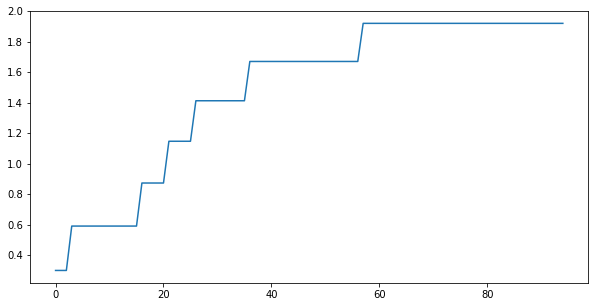

In [26]:
xaxis = np.arange(len(States_track['x-x-5-x-8-9-x-x-4'][(0, 3)]))
plt.figure(0, figsize=(10,5))

plt.plot(xaxis,np.array(States_track['x-x-5-x-8-9-x-x-4'][(0, 3)]))
plt.show()

### Epsilon - decay check

In [24]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

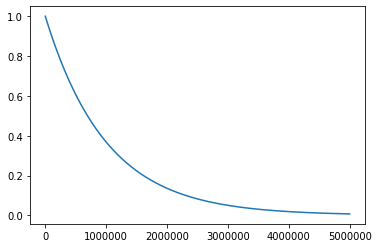

In [25]:
plt.plot(time, epsilon)
plt.show()